<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/Copia_de_01_prediccion_usando_solo_endo%CC%81gena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv 1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

**Notebook: Manuel Sánchez-Montañés**

**Datos: Carlos Rosado**

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='135Md8L6aQhteU6y96uct86spAT89HqNJ',
                                        dest_path='./datos_pasajeros.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 3.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5654 sha256=3b6f5ff4e19f297dbcffb427f373c4e10e646741d3f996034a36d4cdc9f40ed2
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [ ]:
!ls

datos_pasajeros.csv  my_utils_series_temporales.py  sample_data  utils


In [ ]:
import utils.augmentation as aug

In [ ]:
#my util series es para data augmentation en series temporales
#funciones de apoyo

## <font color="#CA3532"> **1. Importar librerías**

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [ ]:
!ls

datos_pasajeros.csv  my_utils_series_temporales.py  sample_data  utils


In [ ]:
data = pd.read_csv('datos_pasajeros.csv')
data.head(10)
# franja 6-12 mañana
# franja tarde 12-18
# franja noche 18-24
#var endógena, la principal, la que quiero predecir.

#quiero predecir n_pasajeros, a partir de las variables futuras
#para ello, enventano, es decir, tengo que limitar el contexto, 
#cuanto miro hacia atrás, paara predecir el valor, "ecuación de recurrencia"

#la evolución de una empresa en bolsa, depende de más cosas que el histórico
#

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,3
1,2015-01-02,1,0,3592,0,4
2,2015-01-03,1,0,3001,0,5
3,2015-01-04,1,0,2260,0,6
4,2015-01-05,1,0,2767,0,0
5,2015-01-06,1,1,1342,0,1
6,2015-01-07,1,0,3867,0,2
7,2015-01-08,1,0,3904,1,3
8,2015-01-09,1,0,3678,1,4
9,2015-01-10,1,0,2631,1,5


In [ ]:
data.tail(10)

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
780,2017-02-19,2,0,2028,1,6
781,2017-02-20,2,0,3578,1,0
782,2017-02-21,2,0,3824,1,1
783,2017-02-22,2,0,3752,2,2
784,2017-02-23,2,0,3913,2,3
785,2017-02-24,2,0,4199,2,4
786,2017-02-25,2,0,2534,2,5
787,2017-02-26,2,0,1816,2,6
788,2017-02-27,2,0,3990,2,0
789,2017-02-28,2,0,3876,2,1


In [ ]:
!ls -la

total 48
drwxr-xr-x 1 root root  4096 Feb  6 08:55 .
drwxr-xr-x 1 root root  4096 Feb  6 08:53 ..
drwxr-xr-x 4 root root  4096 Feb  1 14:31 .config
-rw-r--r-- 1 root root 19189 Feb  6 08:55 datos_pasajeros.csv
-rw-r--r-- 1 root root  4167 Feb  6 08:55 my_utils_series_temporales.py
drwxr-xr-x 1 root root  4096 Feb  1 14:32 sample_data
drwxr-xr-x 3 root root  4096 Feb  6 08:55 utils


In [ ]:
data.shape

(790, 6)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [ ]:
type(data['fecha'][0])

str

In [ ]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['fecha'] = pd.to_datetime(data['fecha'])
type(data['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
data['fecha']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
785   2017-02-24
786   2017-02-25
787   2017-02-26
788   2017-02-27
789   2017-02-28
Name: fecha, Length: 790, dtype: datetime64[ns]

In [ ]:
fechas      = data['fecha'].values
target      = data['npasajeros'].values # variable endógena, la que quiero predecir

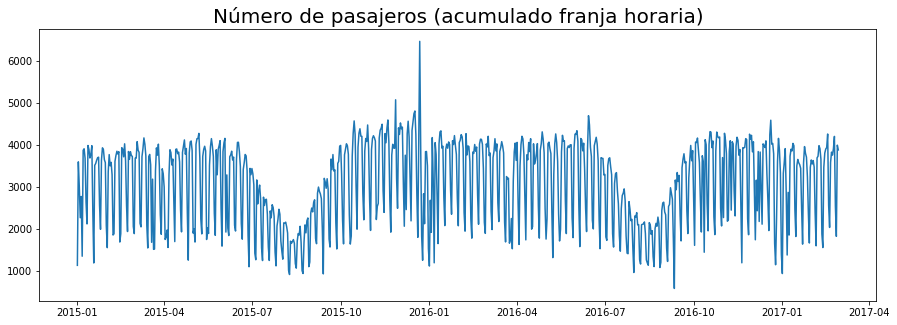

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Número de pasajeros (acumulado franja horaria)',
          fontsize=20);

In [ ]:
#dos bajones, en verano, modula la media, y la amplitud
#hay un pico en navidad, outliet, puede ser evento
#agosto, componente estacional, lento,
#componentes rápidos:

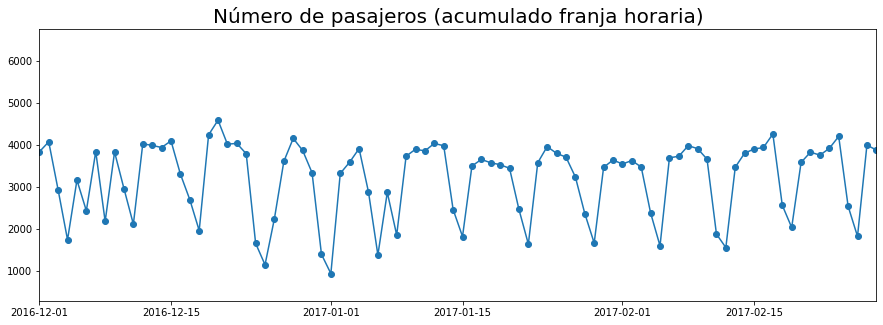

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

In [ ]:
#fin de semana esta línea se utiliza menos
#hay ciclos, pero por ejemplo el 7 se rompe el ciclo al ser fetivo

In [ ]:
if COLAB:
    !cal 1 2017

    January 2017      
Su Mo Tu We Th Fr Sa  
 1  2  3  4  5  6  7  
 8  9 10 11 12 13 14  
15 16 17 18 19 20 21  
22 23 24 25 26 27 28  
29 30 31              
                      


Media número de viajeros    : 3065.5784810126584


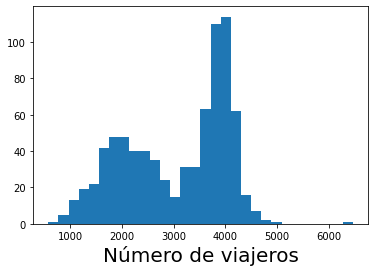

In [ ]:
plt.hist(target, bins=30)
plt.xlabel('Número de viajeros', fontsize=20)
print("Media número de viajeros    :", target.mean())

In [ ]:
#nos salen dos picos, es una distribución Bimodal, 
#pico 1, actividad entre semana, pico dos actividad fin de semana
#el pico menos variante puede que sea entre semana, y el más desparramado el de fin de semana


## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [ ]:
#transformo a ojo / 5000 porque es el numero máximo, quitando outliers

In [ ]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/5000
def inverse_transform(x_escalado):
    return x_escalado*5000

In [ ]:
transform(np.array([1,2,3]))

array([0.0002, 0.0004, 0.0006])

## <font color="#CA3532"> **5. Enventanado de datos**

In [ ]:
''''
en este caso, prodigo nº pasajero en función del numero de pasajero
si mi ventana es predijo hoy mirando los últimos 5 días, 
voy deslizando esa ventana de tamaño fijo
esto es ventana de entrada o loockback, cuantos días miro hacia atrás

Lo ideal es que la ventana sea consistente entre diferentes tiempos, 
no debería ir canviandola, en la práctica si se puede llegar  a programar esto
se busca homogeneidad para que la red aprenda a generalizar un poco mejor
''''

In [ ]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [ ]:
#target

In [ ]:
target_transf = transform(target)
target_transf[:5]

array([0.225 , 0.7184, 0.6002, 0.452 , 0.5534])

In [ ]:
series = [target_transf] 
se_saben_antes = [False] #ahora este no lo uso
nombres_series = ["target_transf"] #para que ponga este nombre

In [ ]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(1, 790)
(1,)


In [ ]:
lookback = 30 # lookback es otro sinónimo de W_in
#para predecir hoy miro 29 días atrás

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":

X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))
#

(790, 30, 1) (790,)


In [ ]:
series[0][:10]

array([0.225 , 0.7184, 0.6002, 0.452 , 0.5534, 0.2684, 0.7734, 0.7808,
       0.7356, 0.5262])

In [ ]:
X[5] #esto es porque los 30 días anteriores a el día 5 no los se, no los tengo


array([[   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [0.225 ],
       [0.7184],
       [0.6002],
       [0.452 ],
       [0.5534]])

In [ ]:
y[5]

0.2684

In [ ]:
fechas_aux = [str(x).split("T")[0] for x in fechas]

In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas_aux)

10 ventanas creadas

X.shape=(10, 30, 1)  Y.shape=(10,) 

 Ventana 0: 


X[0].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 
__
 
 Y[0]=0.225 
 
 
   
 2015-01-01 
 
 
 
 
 target 
 0.225000

 Ventana 1: 


X[1].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 2015-01-01 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 
 
 
__
 
 Y[1]=0.7184 
 
 
   
 2015-01-02 
 
 
 
 
 target 
 0.718400

 Ventana 2: 


X[2].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 2015-01-01 
 2015-01-02 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 
 
 
__
 
 Y[2]=0.6002 
 
 
   
 2015-01-03 
 
 
 
 
 target 
 0.600200

 Ventana 3: 


X[3].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 
 
 
__
 
 Y[3]=0.452 
 
 
   
 2015-01-04 
 
 
 
 
 target 
 0.452000

 Ventana 4: 


X[4].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 
 
 
__
 
 Y[4]=0.5534 
 
 
   
 2015-01-05 
 
 
 
 
 target 
 0.553400

 Ventana 5: 


X[5].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 2015-01-05 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 
 
 
__
 
 Y[5]=0.2684 
 
 
   
 2015-01-06 
 
 
 
 
 target 
 0.268400

 Ventana 6: 


X[6].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 2015-01-05 
 2015-01-06 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 
 
 
__
 
 Y[6]=0.7734 
 
 
   
 2015-01-07 
 
 
 
 
 target 
 0.773400

 Ventana 7: 


X[7].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 2015-01-05 
 2015-01-06 
 2015-01-07 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 
 
 
__
 
 Y[7]=0.7808 
 
 
   
 2015-01-08 
 
 
 
 
 target 
 0.780800

 Ventana 8: 


X[8].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 2015-01-05 
 2015-01-06 
 2015-01-07 
 2015-01-08 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 
 
 
__
 
 Y[8]=0.7356 
 
 
   
 2015-01-09 
 
 
 
 
 target 
 0.735600

 Ventana 9: 


X[9].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 2015-01-01 
 2015-01-02 
 2015-01-03 
 2015-01-04 
 2015-01-05 
 2015-01-06 
 2015-01-07 
 2015-01-08 
 2015-01-09 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 0.735600 
 
 
 
__
 
 Y[9]=0.5262 
 
 
   
 2015-01-10 
 
 
 
 
 target 
 0.526200

In [ ]:
print(X.shape)
print(np.shape(target))

(790, 30, 1)
(790,)


## <font color="#CA3532"> **6. Separación training-test**

In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)
punto_corte

632

In [ ]:
#ahora la particiión no se hace aleatoria sino que la corto por un día
#empizo a partir de dicha ventana porque sino tendré nan

In [ ]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(602,)
(158,)


In [ ]:
print(X_train.shape, y_train.shape)

(602, 30, 1) (602,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [ ]:
from keras.layers import LSTM

In [ ]:
loss = 'mean_squared_error'
#loss = "mean_absolute_percentage_error"

#optimizer = "adam"
optimizer="rmsprop"
#optimizer=optimizers.Adam(learning_rate=0.01), # más rápido

USAR_LSTM = False

model = Sequential()

if USAR_LSTM:
    model.add(LSTM(5, input_shape=(lookback, X_train.shape[-1])))
    model.add(Dense(1))
else:
    model.add(Conv1D(4, kernel_size=5, input_shape=(lookback, X_train.shape[-1])))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(8, kernel_size=5))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(1, # kernel_regularizer='l1' / puedo poner sigm poq lo limitaria, relu podria ser pq no puede se run num negativo de pasajeros 
                  )
            )

model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [ ]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 4)             24        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 8)              168       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 8)             0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
''''
vemos que le pasamos lo que ha pasado los últimos 
30 días, con 1 serie edógena, 1 canal, 

le paso una convolución, comparo cada día, dos días hacia atrás, dis días,
hacia delante, entonces, al tener un canal, lo viltos serán vectores, 
en caso de las imagenes, tendria un tensor, en caso que pase varias series, 
no tendre filtros vectores, pero en etse caso si lo son. 

como el tamaño del kernel es 5 estoy pasando de 30 a 26 por el efecto border, 
entonces tengo 4 filtros. pierdo dos datos por la derecha y dos por la izquierda
si hiciera padding, seguiria conservando 30, 
estamos sacando 4 tipos de patrones diferentes

maxPool = 2 entonces unidad de tiempo son 2 dñias
''''

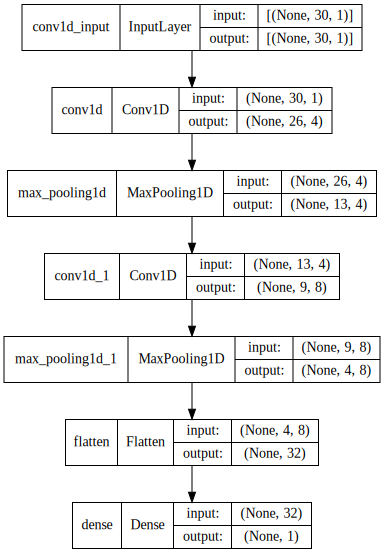

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
OS_WINDOWS = False

# Creación del directorio log en el que se va a grabar
# el grafo del modelo y resultados intermedios del proceso
# de training para visualizarlo luego en Tensorboard

log_path = 'log/'

tb_callback = TensorBoard(
    log_dir=log_path,
    histogram_freq=2,
    write_graph=True
)
tb_callback.set_model(model)
callbacks = []
callbacks.append(tb_callback)

# A continuación se trata de crear el directorio log:
# - Si no existe se crea
# - Si ya existe se borran los datos que haya dentro de él

try:
    os.mkdir(log_path)
except:
    if OS_WINDOWS:
        !del log\*
    else:
        !rm log/*

rm: cannot remove 'log/train': Is a directory



Epoch 00001: val_mse improved from inf to 0.03162, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03162 to 0.03131, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03131 to 0.02921, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.02921 to 0.02494, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.02494 to 0.02455, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.02455 to 0.02357, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.02357 to 0.02021, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.02021

Epoch 00001: val_mse improved from 0.02021 to 0.01704, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.01704

Epoch 00001: val_mse did not improve from 0.01704

Epoch 00001: val_mse improved from 0.01704 to 0.01520, saving model to model_current_best.h5

Epoc

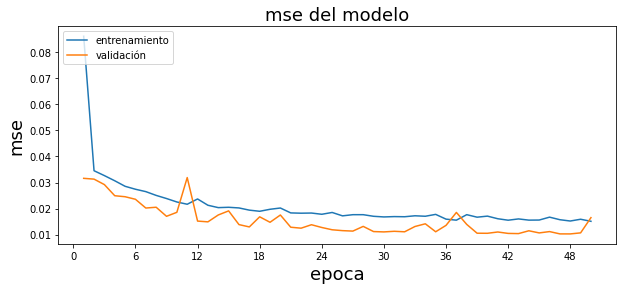


Epoch 00001: val_mse did not improve from 0.01027

Epoch 00001: val_mse improved from 0.01027 to 0.01013, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse did not improve from 0.01013

Epoch 00001: val_mse improved from 0.01013 to 0.00981, saving model to model_current_best

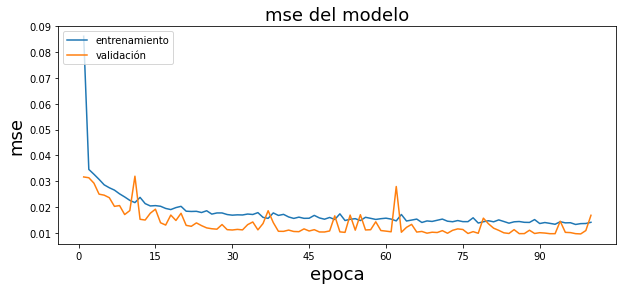


Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not improve from 0.00953

Epoch 00001: val_mse did not i

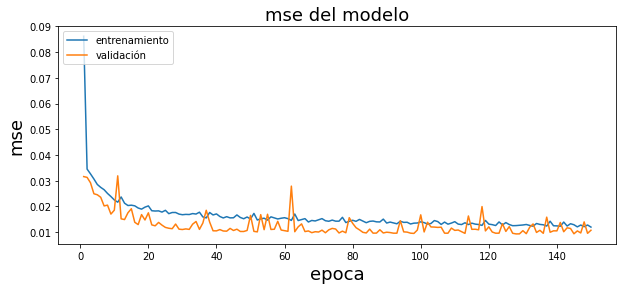


Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse did not improve from 0.00933

Epoch 00001: val_mse improved from 0.00933 to 0.00932, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00932

Epoch 00001: val_mse did not improve from 0.00932

Epoch 00001: val_mse did not improve from 0.00932

Epoch 00001: val_mse did not improve from 0.00932

Epoch 00001: val_mse improved from 0.00932 to 0.00925, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00925

Epoch 00001: val_mse did not improve from 0.00

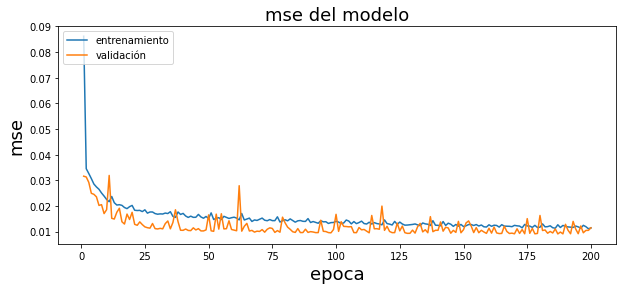

In [ ]:
epochs = 200
batch_size = 64
Nval = 200
control_sobreajuste_val = True
grabar_detalles_training_para_tensorboard = False
# si no se van a analizar estos detalles en tensorboard mejor
# poner este flag a False ya que el grabarlos enlentence
# bastante el training

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    if grabar_detalles_training_para_tensorboard:
        callbacks_list = callbacks + [checkpoint]
    else:
        callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [ ]:
y_train_prediction = model.predict(X_train).flatten() 
#si no hago el flatten, me sale un array con un corchete adicional, como solo tengo una neutrona como que sobra el corchete y así lo cepillo
y_test_prediction = model.predict(X_test).flatten()
y_train_prediction[:5]

array([0.5033267 , 0.36866787, 0.69354934, 0.69997686, 0.74078614],
      dtype=float32)

In [ ]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

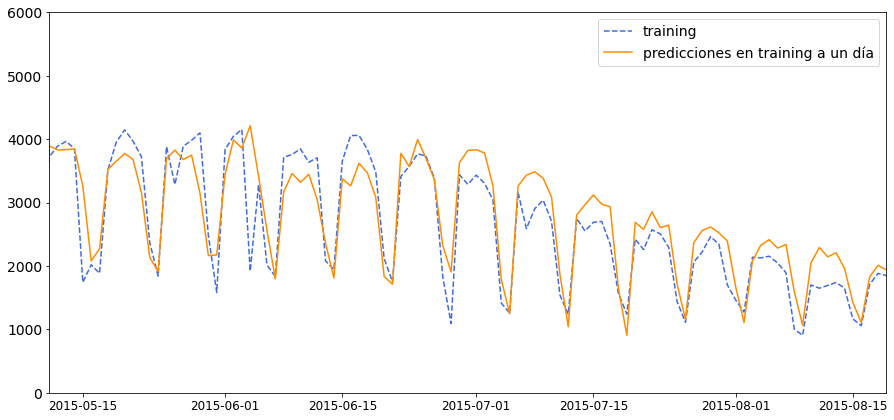

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[100],fechas_train[200],0,6000])
plt.legend(fontsize=14);

#estamos haciendo predicciones a un día, 

In [ ]:
data[151:160]

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
151,2015-06-01,6,0,3837,0,0
152,2015-06-02,6,0,4044,0,1
153,2015-06-03,6,0,4152,0,2
154,2015-06-04,6,1,1918,0,3
155,2015-06-05,6,0,3281,0,4
156,2015-06-06,6,0,2016,0,5
157,2015-06-07,6,0,1835,0,6
158,2015-06-08,6,0,3714,1,0
159,2015-06-09,6,0,3757,1,1


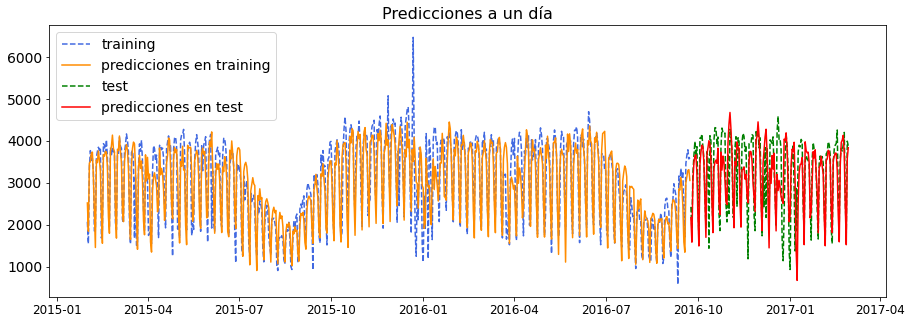

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

#zona roja es test

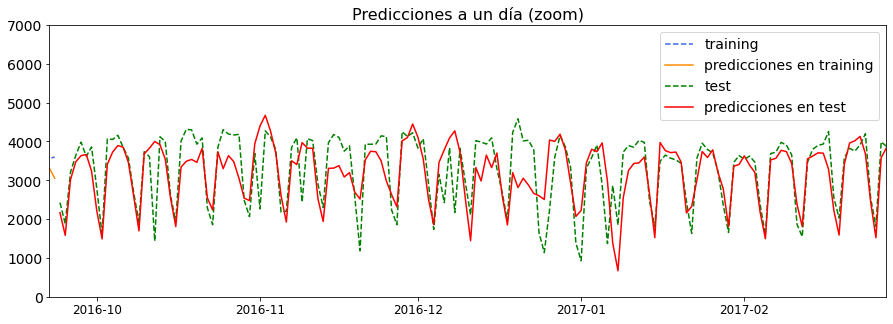

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[600],fechas_test[-1],0,7000]);

#hay que ver que mi modelo no está desfasado

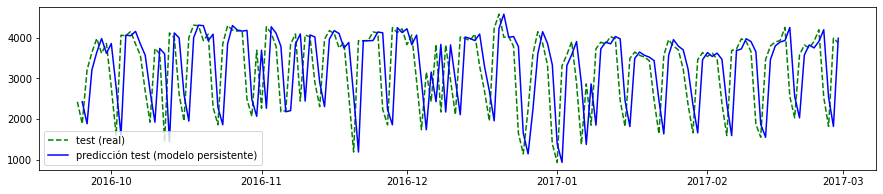

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test (real)')
plt.plot(fechas_test[1:], target_test[:-1], '-',   c='blue',
         label='predicción test (modelo persistente)')
plt.legend();
#MODELO PERSISTENTE = modelo desfasado, en este caso, pedice para mañana lo mismo
#que hoy, no está prediciendo bien, está perdido, 

Coeficiente de determinación R2 (no r2 de Pearson)#

1 - ecm / var(y real)

In [ ]:
#para modelos de regresión, 
#una manera de determinar el error es con el R^2, coeficiente de determinación


In [ ]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.7438553062054664
R2 del modelo en test          :  0.46556031400956555
R2 modelo persistente 1 día    :  -0.44768351889101354
R2 modelo persistente 1 semana :  0.3743300534633949
R2 modelo persistente 4 semanas:  0.48525679455105053
R2 modelo persistente 1 año:  0.7023710033430108


In [ ]:
#conclusion, score malo, habria que mejorar el modelo

In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  514.5584554421094
RMSE del modelo en test          :  664.3092239451836
RMSE modelo persistente 1 día    :  1093.8023843688381
RMSE modelo persistente 1 semana :  724.5713553588926
RMSE modelo persistente 4 semanas:  654.1568971996292


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

¿Cómo hago para predecir, si hoy es sábado, el número de pasajeros el lunes?

El número de pasajeros los 4 últimos días, y los de hoy son:

[100, 300, 200, 500, 700]

- Primero: predices pasajeros mañana domingo. Por ejemplo, la red dice que son 1000

- Segundo: asumes que la predicción es completamente correcta, y construyes la ventana para mañana:

[300, 200, 500, 700, **1000**]

- Tercero: predices con esa ventana el número de pasajeros el lunes.

In [ ]:
def step_generativo(model, ventana, X, i):
    # ventana: va a tener dimensiones (1, lookback, n_variables)
    # El target está en (0,:,0)
    # La posición (0,0,0) es el target en el día más antiguo de la ventana
    # La posición (0,0,-1) es el target en el día más reciente de la ventana
    # Las variables calendario están en (0,:,1:)
    # Las variables calendario para el último día de la ventana están en (0,-1,1:)

    z = model.predict(ventana)[0,0] # predicción nueva
    target_pred = inverse_transform(z)
    ventana_nueva = None
    if i < (len(X)-1):
        ventana_nueva = np.zeros(ventana.shape)
        # muevo un día hacia atrás todas las variables de la ventana:
        ventana_nueva[0,:-1,:] = ventana[0,1:,:].copy()

        # introduzco las variables calendario para el último día de la ventana:
        ventana_nueva[0,-1,1:] = X[i+1,-1,1:]

        # meto la predicción como última obervación del target:
        ventana_nueva[0,-1,0] = z
        
        
    return target_pred, ventana_nueva

In [ ]:
#de esta manera el error se va acumulando

In [ ]:
def generativo(model, X):
    ventana = np.array([X[0]]).copy()    
    salidas = []
    for i in range(len(X)):
        target_pred, ventana_nueva = step_generativo(model, ventana, X, i)
        salidas.append(target_pred)
        ventana = ventana_nueva
    
    return salidas

In [ ]:
sal = generativo(model, X_test)

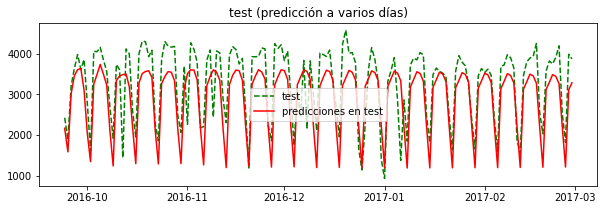

In [ ]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();

In [ ]:
if grabar_detalles_training_para_tensorboard:
    import webbrowser
    if COLAB:
        %load_ext tensorboard
        %tensorboard --logdir $log_path
    else:
        webbrowser.open_new('http://localhost:6006')
        os.system('tensorboard --logdir=' + log_path)

### **"Heatmaps" de la predicción: ¿qué inputs han influido más en la predicción?**

In [ ]:
print(nombres_series)
print(len(nombres_series))
print(X_test.shape)

['target_transf']
1
(158, 30, 1)


In [ ]:
len(se_saben_antes)

1

In [ ]:
i = 0
print(fechas_test[i]) # 24/09/2016 fue sábado
sample = X_test[i:(i+1)].copy()
sample.shape

2016-09-24T00:00:00.000000000


(1, 30, 1)

In [ ]:
info_enventanado(X_test[i:(i+1)],y[i:(i+1)],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas_test[i:(i+1)])

1 ventanas creadas

X.shape=(1, 30, 1)  Y.shape=(1,) 

 Ventana 0: 


X[0].shape=(30, 1) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 
 
 
 
 target_transf 
 0.455000 
 0.423200 
 0.214600 
 0.239000 
 0.486400 
 0.522400 
 0.526200 
 0.479800 
 0.466000 
 0.306400 
 0.243600 
 0.505400 
 0.515600 
 0.595000 
 0.566800 
 0.540600 
 0.346200 
 0.114800 
 0.631800 
 0.585400 
 0.667600 
 0.624800 
 0.653800 
 0.461000 
 0.341400 
 0.690600 
 0.731000 
 0.757000 
 0.713400 
 0.719400 
 
 
 
__
 
 Y[0]=0.225 
 
 
   
 2016-09-24 00:00:00 
 
 
 
 
 target_transf 
 0.225000

In [ ]:
pred0 = model.predict(sample)[0][0]
delta = 1e-3
w_in = sample.shape[1]

print("SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:\n")
for i,x in enumerate(nombres_series):
    for j in range(w_in):
        sample_pert = sample.copy()
        sample_pert[0,j,i] += delta
        pred_pert = model.predict(sample_pert)[0][0]
        if se_saben_antes[i]:
            print("{} (t-{}) [ADELANTADA]: {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))
        else:
            print("{} (t-{}): {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))

SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:

target_transf (t-30): 0.061
target_transf (t-29): 0.017
target_transf (t-28): 0.025
target_transf (t-27): -0.109
target_transf (t-26): 0.021
target_transf (t-25): -0.027
target_transf (t-24): 0.041
target_transf (t-23): -0.025
target_transf (t-22): 0.023
target_transf (t-21): 0.122
target_transf (t-20): 0.068
target_transf (t-19): -0.279
target_transf (t-18): -0.017
target_transf (t-17): -0.199
target_transf (t-16): 0.348
target_transf (t-15): 0.014
target_transf (t-14): 0.208
target_transf (t-13): 0.012
target_transf (t-12): -0.238
target_transf (t-11): -0.032
target_transf (t-10): 0.070
target_transf (t-9): 0.085
target_transf (t-8): 0.181
target_transf (t-7): 0.261
target_transf (t-6): 0.124
target_transf (t-5): 0.100
target_transf (t-4): -0.032
target_transf (t-3): 0.004
target_transf (t-2): 0.000
target_transf (t-1): 0.000


### **Función que saca por pantalla todos los parámetros de todas las capas de la red**

In [ ]:
def info_red(modelo):
    for i,layer in enumerate(modelo.layers):
        print('* Capa {} [Nombre: "{}"]'.format(i,layer.name))
        print('  Tipo:', type(layer))
        print("  Propiedades:")
        aux = layer.get_config()
        for k in aux:
            print("    {}: {}".format(k, aux[k]))
        print()

In [ ]:
# información detallada de todos los parámetros de cada capa del modelo:
info_red(model)

* Capa 0 [Nombre: "conv1d"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>
  Propiedades:
    name: conv1d
    trainable: True
    batch_input_shape: (None, 30, 1)
    dtype: float32
    filters: 4
    kernel_size: (5,)
    strides: (1,)
    padding: valid
    data_format: channels_last
    dilation_rate: (1,)
    groups: 1
    activation: linear
    use_bias: True
    kernel_initializer: {'class_name': 'GlorotUniform', 'config': {'seed': None}}
    bias_initializer: {'class_name': 'Zeros', 'config': {}}
    kernel_regularizer: None
    bias_regularizer: None
    activity_regularizer: None
    kernel_constraint: None
    bias_constraint: None

* Capa 1 [Nombre: "max_pooling1d"]
  Tipo: <class 'keras.layers.pooling.MaxPooling1D'>
  Propiedades:
    name: max_pooling1d
    trainable: True
    dtype: float32
    strides: (2,)
    pool_size: (2,)
    padding: valid
    data_format: channels_last

* Capa 2 [Nombre: "conv1d_1"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>
  Propi